# 1. Load libraries and connect to server via CMD

<!-- ### Connect to server
- ✅ Every time you restart your machine, you'll need to run the `ssh command` again to establish the Serveo tunnel.

```
ssh -R 7687:localhost:7687 serveo.net

ssh -R 0:localhost:7687 serveo.net -->
```

- ✅ activate Neo4j database and run the connection code.

```
URI = "bolt://serveo.net:7687"
USERNAME = "neo4j"
PASSWORD = "your password"

driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

```

In [8]:
import plotly.graph_objects as go
# import plotly.graph_objs as go
# import matplotlib.pyplot as plt
# import random
from neo4j import GraphDatabase
# import pandas as pd
import networkx as nx
# from collections import defaultdict
# from collections import Counter
from transformers import AutoTokenizer, AutoModelForCausalLM #, pipeline
import torch

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("neo4j.notifications").setLevel(logging.ERROR) # Suppress Neo4j deprecation and notification warnings

# 2. Connect to Neo4j

In [9]:
# Connect to Neo4j
URI = "bolt://localhost:7687"

USERNAME = "neo4j"
PASSWORD = "macad2025"

# Create a Neo4j driver
driver = GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

# Verify connectivity
try:
    driver.verify_connectivity()
    print("Connection successful!")
except Exception as e:
    print("Connection failed:", e)

Connection successful!


# 3. Cypher
## 3.1. Function for running the Cypher request

In [10]:
def run_cypher(query, params=None, write=False):
    """
    Executes a Cypher query on the Neo4j database.

    Parameters:
      - query (str): The Cypher query to be executed.
      - params (dict, optional): A dictionary of parameters for the query.
      - write (bool, optional): Set to True if this is a write transaction, otherwise False (default).

    Returns:
      - list[dict]: The query result as a list of dictionaries.
    """
    if params is None:
        params = {}

    # Open a new session with the database
    with driver.session() as session:
        # Depending on the type of transaction, use read or write
        if write:
            result = session.execute_write(lambda tx: tx.run(query, **params).data())
        else:
            result = session.execute_read(lambda tx: tx.run(query, **params).data())
    return result

### Query to fetch N nodes from the database.

In [16]:
query = "MATCH (n) RETURN n LIMIT 25"
result_data = run_cypher(query)
result_data

# output structure -> list of dicts

[{'n': {'IfcType': 'IfcSpace',
   'ObjectType': nan,
   'LocationY': 20.376091,
   'Description': nan,
   'LocationZ': 4.5,
   'LocationX': -39.208039,
   'SolarRad': 0.0,
   'Tag': 0.0,
   'category': 'IfcSpace',
   'GlobalId': '0hlmsO3TX3kfSCEYMAtENu',
   'Unnamed: 0': '0hlmsO3TX3kfSCEYMAtENu',
   'Name': 'LVL1_1B_72'}},
 {'n': {'IfcType': 'IfcSpace',
   'ObjectType': nan,
   'LocationY': 62.376091,
   'Description': nan,
   'LocationZ': 4.5,
   'LocationX': -39.208039,
   'SolarRad': 0.0,
   'Tag': 0.0,
   'category': 'IfcSpace',
   'GlobalId': '3X95yfnqPDVQbtUITG$ppG',
   'Unnamed: 0': '3X95yfnqPDVQbtUITG$ppG',
   'Name': 'LVL1_1B_80'}},
 {'n': {'IfcType': 'IfcSpace',
   'ObjectType': nan,
   'LocationY': 20.376091,
   'Description': nan,
   'LocationZ': 4.5,
   'LocationX': -30.208038,
   'SolarRad': 0.0,
   'Tag': 0.0,
   'category': 'IfcSpace',
   'GlobalId': '2W18n9Wmn10BQxqA98Gkq5',
   'Unnamed: 0': '2W18n9Wmn10BQxqA98Gkq5',
   'Name': 'LVL1_1B_98'}},
 {'n': {'IfcType': 'IfcSp

### Retrieve the total number of IfcType elements

In [17]:
query = """
MATCH (n)
WHERE n.IfcType = 'IfcColumn'
RETURN count(n) AS total_Columns
"""
result_data = run_cypher(query)
print(*result_data)

{'total_Columns': 1629}


### Retrieve elements with a parameter condition

In [ ]:
# here we pick elements via type and area -> any numeric data could work!
query = """
MATCH (n)
WHERE n.IfcType = 'IfcSpace' AND n.NetFloorArea > 300
RETURN n
"""
result_data = run_cypher(query)
print(f'Total number of rooms: {len(result_data)}')
print('-'*10, 'retrieved nodes', '-'*10)
result_data

Total number of rooms: 0
---------- retrieved nodes ----------


[]

### Match an element by GlobalId and then get all its connected elements

In [19]:
query = """
MATCH (n)
WHERE $globalId IS NOT NULL AND n.GlobalId = $globalId
MATCH (n)-[r]-(m)
RETURN n, r, m
"""

# Define the parameter with the desired GlobalId
params = {"globalId": "3sM$t_Teb2q92lD380TwKD"}

result_data = run_cypher(query, params)
print(f'Total numer of connected elements: {len(result_data)}')
# result_data

Total numer of connected elements: 26


### Visualize the retrieved IFC element extracted in the previous step

In [20]:
def get_color_for_ifc_type(ifc_type):
    # Use the built-in hash function to generate a hex color code.
    return f"#{hash(ifc_type) & 0xFFFFFF:06x}"

G = nx.Graph()

# Loop through each record from the query results
for record in result_data:
    n = record["n"]
    m = record["m"]

    # Use GlobalId as the unique identifier for each node
    n_id = n.get("GlobalId")
    m_id = m.get("GlobalId")

    # Add nodes with their properties if they are not already added
    G.add_node(n_id, **n)
    G.add_node(m_id, **m)

    # Add an edge between the two nodes
    G.add_edge(n_id, m_id)

# Compute a 3D spring layout (x, y, z coordinates) for the graph
pos = nx.spring_layout(G, dim=3, seed=42)

# Build edge traces for 3D plotting
edge_x, edge_y, edge_z = [], [], []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

# Build node traces for 3D plotting and assign colors based on IfcType
node_x, node_y, node_z, node_text, node_color = [], [], [], [], []
for node in G.nodes(data=True):
    node_id = node[0]
    attr = node[1]
    x, y, z = pos[node_id]
    node_x.append(x)
    node_y.append(y)
    node_z.append(z)

    # Prepare hover text using GlobalId and IfcType
    ifc_type = attr.get("IfcType", "Unknown")
    node_text.append(f"GlobalId: {node_id}<br>IfcType: {ifc_type}<br>Name: {attr.get('Name', 'N/A')}")

    # Set the node color based on IfcType
    node_color.append(get_color_for_ifc_type(ifc_type))

node_trace = go.Scatter3d(
    x=node_x, y=node_y, z=node_z,
    mode='markers',
    marker=dict(
        size=8,
        color=node_color,
        line=dict(width=0)
    ),
    text=node_text,
    hoverinfo='text'
)

# Create and show the 3D figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=dict(text="3D Graph Visualization Colored by IfcType. Connected elements", font=dict(size=16)),
                    showlegend=False,
                    margin=dict(l=0, r=0, b=0, t=40),
                    scene=dict(
                        xaxis=dict(showbackground=False, showticklabels=False, title=''),
                        yaxis=dict(showbackground=False, showticklabels=False, title=''),
                        zaxis=dict(showbackground=False, showticklabels=False, title='')
                    )
                ))
fig.show()

Similar request in Neo4j Browser

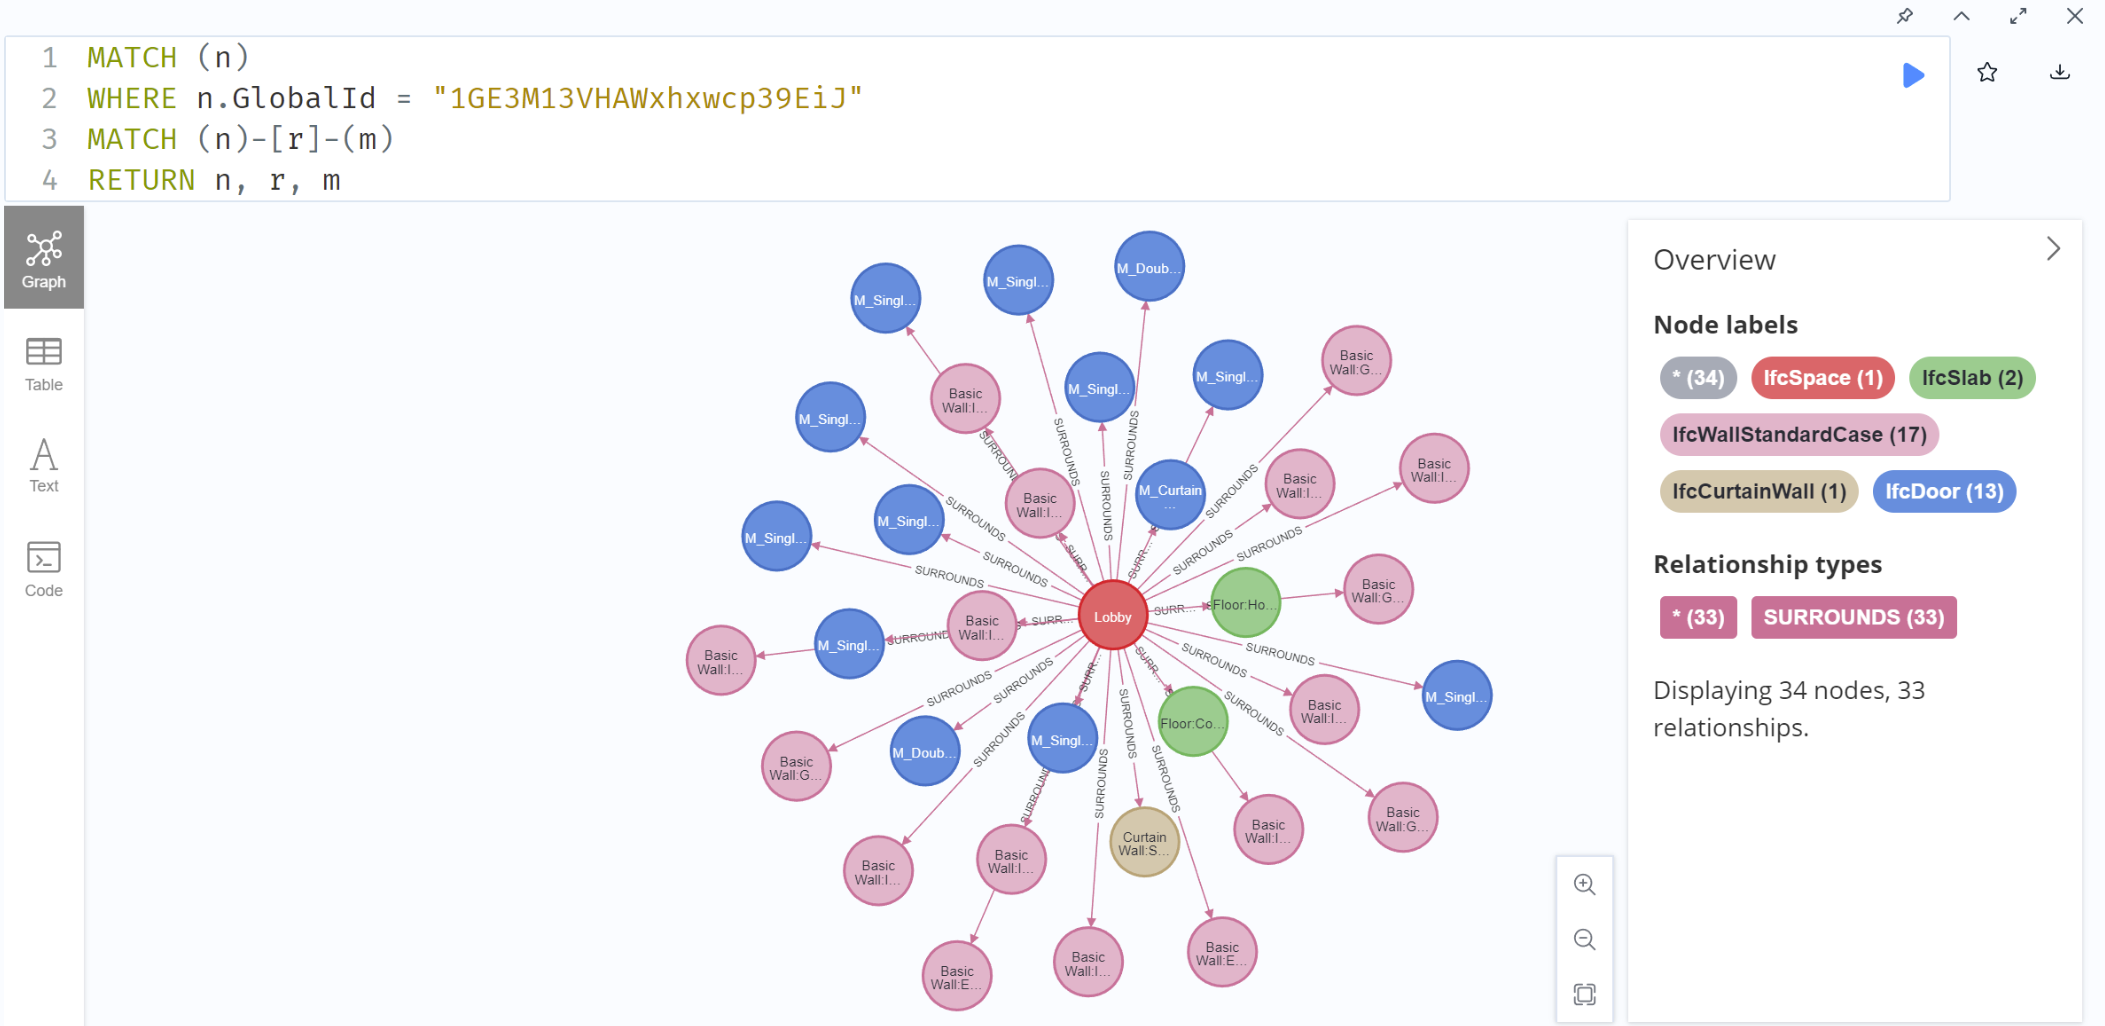

### Retrieve Distinct IfcTypes

In [21]:
query = """
MATCH (n)
RETURN DISTINCT n.IfcType AS IfcType
ORDER BY IfcType
"""

result_data = run_cypher(query, params)
print(len(result_data))
result_data

7


[{'IfcType': 'IfcColumn'},
 {'IfcType': 'IfcDoor'},
 {'IfcType': 'IfcSlab'},
 {'IfcType': 'IfcSpace'},
 {'IfcType': 'IfcStair'},
 {'IfcType': 'IfcWall'},
 {'IfcType': 'IfcWindow'}]

### Retrieve Maximum and Minimum Areas for IfcSpaces

In [22]:
# any numeric data could work, here we extract min and max
query = """
MATCH (n:IfcSpace)
RETURN max(n.NetFloorArea) AS Max_Area, min(n.NetFloorArea) AS Min_Area
"""

result_data = run_cypher(query, params)
print(*result_data)

{'Max_Area': None, 'Min_Area': None}


### Retrieve Elements with Missing or Null Properties

In [23]:
query = """
MATCH (n)
WHERE n.Area IS NULL OR n.Name IS NULL
RETURN n
"""

result_data = run_cypher(query, params)
len(result_data)

3805

### Retrieve and Sort Elements with Parameter (GrossVolume) Above a Threshold

In [24]:
# numeric data needed
query = """
MATCH (n)
WHERE n.GrossVolume > 1000
RETURN n
ORDER BY n.GrossVolume DESC
"""

result_data = run_cypher(query, params)
print(f'Total elements sorted: {len(result_data)}')
print('-'*13, 'retrieved nodes', '-'*13)
# result_data
# here we extract only data we need from each node
for item in result_data:
    node = item['n']
    family_and_type = node.get('Family and Type')
    category = node.get('category')
    area = node.get('GrossVolume')

    print(f"Family and Type: {family_and_type}")
    print(f"Category: {category}")
    print(f"GrossVolume: {area:.2f}")
    print('-' * 40)

Total elements sorted: 0
------------- retrieved nodes -------------


### Retrieve Elements Grouped by Edge type

In [25]:
query = """
MATCH (a)-[r:VOIDS]->(b)
RETURN a, r, b
LIMIT 5
"""

result_data = run_cypher(query, params)
print(f'Total elements pairs retrieved: {len(result_data)}')
print('-'*13, 'retrieved nodes', '-'*13)
# result_data
# here we extract only elements names and category
for item in result_data:
    node_a = item['a']
    node_b = item['b']

    a_gid = node_a.get('GlobalId')
    a_category = node_a.get('category')

    b_gid = node_b.get('GlobalId')
    b_category = node_b.get('category')

    print(f"{b_gid} ({b_category})")
    print("   ⬇️ VOIDS")
    print(f"{a_gid} ({a_category})")
    print('-' * 60)

Total elements pairs retrieved: 5
------------- retrieved nodes -------------
2zdWlwgSz8o9G2jpwMqeL$ (IfcWindow)
   ⬇️ VOIDS
1_2cirtfH1ARPCSLMw_JEe (IfcWall)
------------------------------------------------------------
0Fo_vRoRX5uQXTgGB2Ak7E (IfcWindow)
   ⬇️ VOIDS
15a1uvAib5Cx3_GHZZjT$N (IfcWall)
------------------------------------------------------------
3PTIC7DOD08hAxsL1sR9av (IfcDoor)
   ⬇️ VOIDS
0L35anL1L1eRLeZClmOIj1 (IfcWall)
------------------------------------------------------------
3PI99POtLD1ODg9lCMRvR5 (IfcWindow)
   ⬇️ VOIDS
2RdVpucjT5jwXsBeM4IE_j (IfcWall)
------------------------------------------------------------
3V0QsMYk99aAWt55D23uAu (IfcDoor)
   ⬇️ VOIDS
0JM4QEsYX22Q0e8lf9TusT (IfcWall)
------------------------------------------------------------


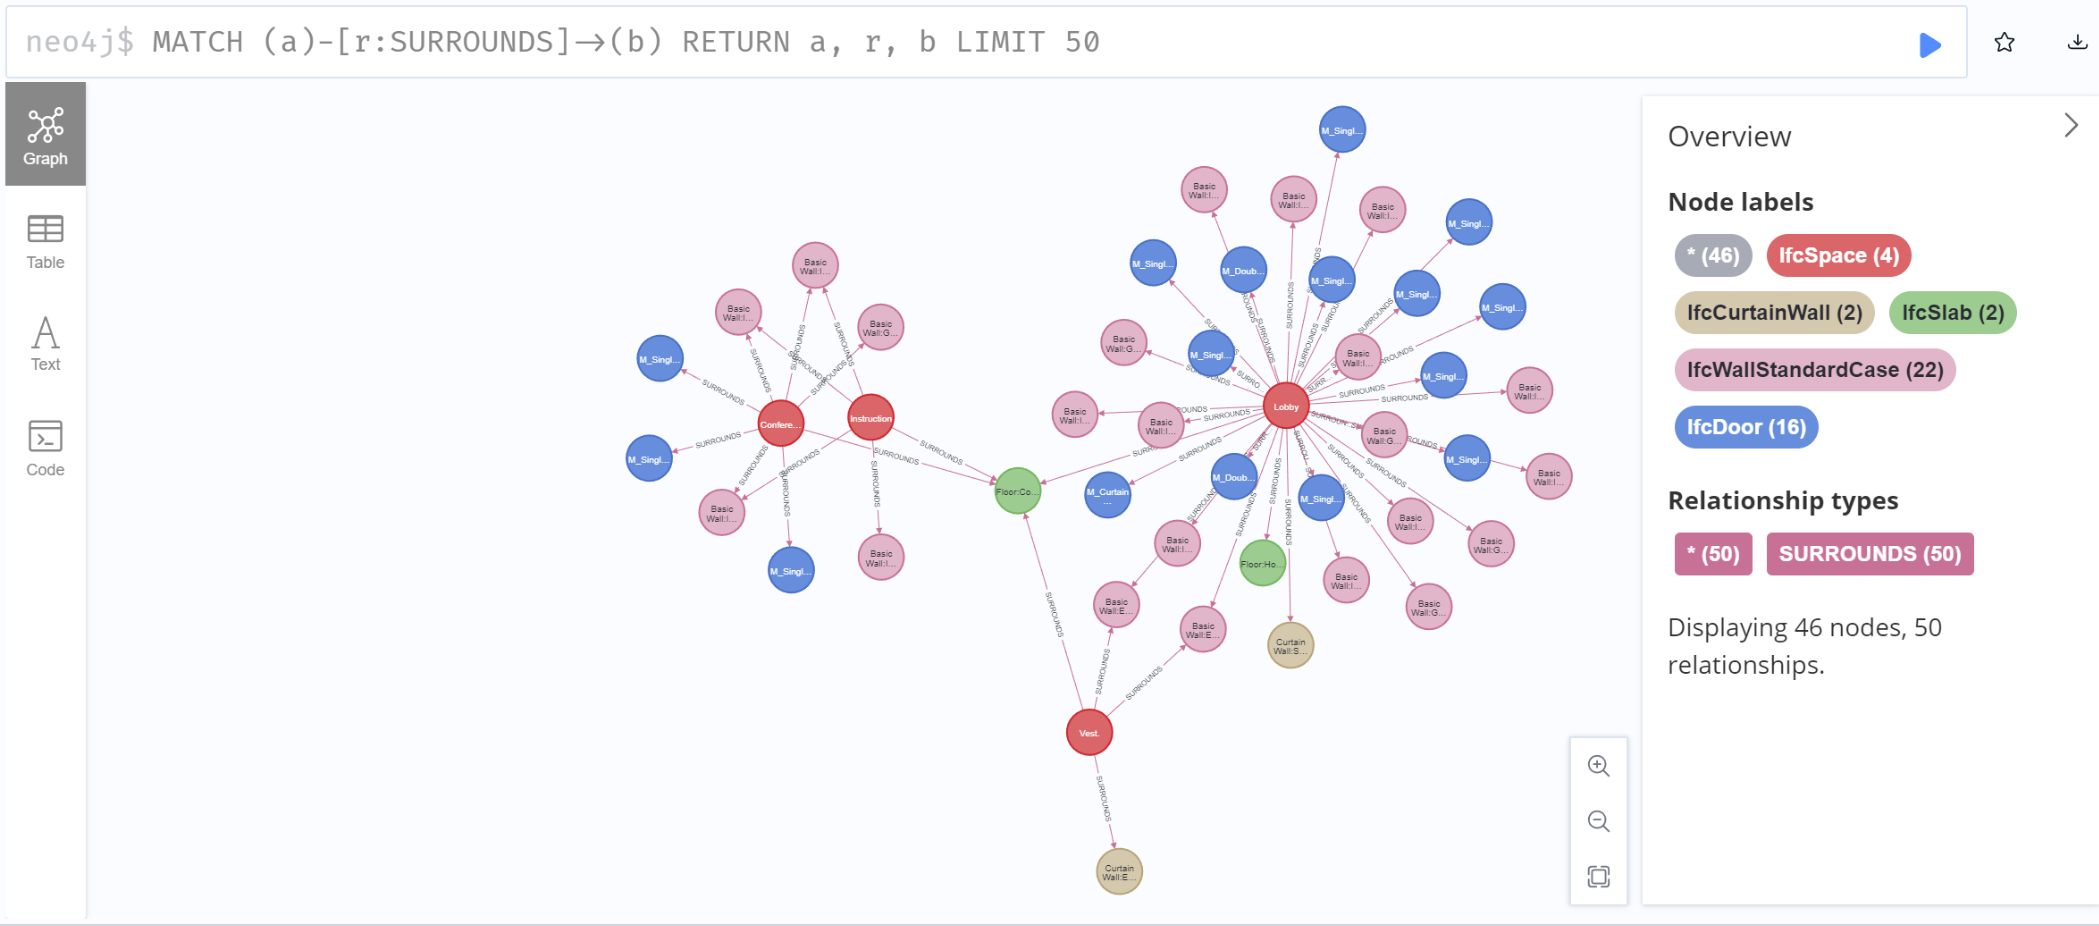

### Retrieve Elements Within a Specific Height Range and Useful Data

In [26]:
query = """
MATCH (n)
WHERE n.Height > 2 AND n.Height <= 3
RETURN n
ORDER BY n.Height
LIMIT 5
"""

result_data = run_cypher(query, params)
print(f'Total elements: {len(result_data)}')
print('-'*13, 'retrieved nodes', '-'*13)
# result_data

for item in result_data:
    node = item['n']
    gid = node.get('GlobalId')
    category = node.get('category')
    reference = node.get('HandicapAccessible')
    height = node.get('Height')

    print(f" GlobalId: {gid},\n HandicapAccessible: {reference},\n Height: {height},\n Category: {category}")
    print('-'*40)

Total elements: 0
------------- retrieved nodes -------------


### Retrieve Elements with excluded category

In [28]:
query = """
MATCH (n)
WHERE NOT n.category IN ['IfcSpace', 'IfcWall']
RETURN n
LIMIT 50
"""

# or WHERE n.category <> 'IfcSpace'

result_data = run_cypher(query, params)
print(f'Total elements: {len(result_data)}')
# result_data

for item in result_data:
    node = item['n']
    gid = node.get('GlobalId')
    category = node.get('category')
    print(f" GlobalId: {gid},\n Category: {category}")
    print('-'*40)

Total elements: 50
 GlobalId: 2zdWlwgSz8o9G2jpwMqeL$,
 Category: IfcWindow
----------------------------------------
 GlobalId: 0Fo_vRoRX5uQXTgGB2Ak7E,
 Category: IfcWindow
----------------------------------------
 GlobalId: 3PI99POtLD1ODg9lCMRvR5,
 Category: IfcWindow
----------------------------------------
 GlobalId: 0EfUgccmLBNuRtTg0C$NuT,
 Category: IfcWindow
----------------------------------------
 GlobalId: 27IwGuBxb6sxGgXIYwtV8Y,
 Category: IfcWindow
----------------------------------------
 GlobalId: 0AM1Pfptr6qvAQRCDyi7d6,
 Category: IfcWindow
----------------------------------------
 GlobalId: 2lhPsTKPTCGfCdp0W$ERWF,
 Category: IfcWindow
----------------------------------------
 GlobalId: 1KfLHTNAf9sxyVKV4orbWI,
 Category: IfcWindow
----------------------------------------
 GlobalId: 1zNzMY6t98TeIgdSOeUX7L,
 Category: IfcWindow
----------------------------------------
 GlobalId: 2UzNs$6dvEi8WwxOdrO9i9,
 Category: IfcWindow
----------------------------------------
 GlobalId: 

### Retrieve Rooms with `HandicapAccessible == True`

In [29]:
query = """
MATCH (n)
WHERE n.`HandicapAccessible` = True
RETURN n.`HandicapAccessible` AS Accessible, count(n) AS Count
"""

result_data = run_cypher(query)
print(f'Total HandicapAccessible: {len(result_data)}')
print('-'*13, 'count by phase', '-'*13)
print(*result_data)

Total HandicapAccessible: 0
------------- count by phase -------------



# 4. LLM to Cypher

-> to GPU


In [ ]:
# Load Code LLaMA Instruct model (change to 13B / 34B as needed)
# Loaded from Hugging face
model_id = "codellama/CodeLlama-7b-Instruct-hf"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

tokenizer_config.json:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
system_prompt = (
    "You are a Cypher expert. The Neo4j graph database contains only nodes labeled: "
    "IfcColumn, IfcWall, IfcSpace, IfcWindow, IfcDoor, and relationships are limited to SURROUNDS and VOIDS. "
    "Relationships are always undirected and written exactly as -[:SURROUNDS]- or -[:VOIDS]-. "
    "Node properties are strictly case-sensitive. Available properties include: "
    "'Name' (capital N, used typically with IfcSpace), 'HandicapAccessible' (boolean, ONLY for IfcSpace nodes). "
    "When the user's question is about counting nodes based on their properties WITHOUT explicitly mentioning "
    "relationships, NEVER use or introduce any relationships in the query. "
    "ONLY if the user's question explicitly mentions relationships or words like 'surrounds' or 'voids', "
    "then and only then include a relationship in the query. "
    "Always use exact property capitalization as given ('Name' not 'name', 'HandicapAccessible'). "
    "Only return the Cypher query, no explanations."
)

In [ ]:
def generate_cypher_with_codellama(question):
    prompt = f"[INST] {system_prompt} \n{question} [/INST]"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    generated = decoded.split("[/INST]")[-1].strip()
    return generated

In [ ]:
def generate_human_response(question, cypher_query, raw_data):
    response_prompt = (
        "You are an assistant that interprets results from Cypher queries executed on a Neo4j database. "
        "You will receive a user's original question, the Cypher query executed, and its raw result. "
        "Provide a concise, human-readable answer to the user's original question based on this information. "
        "Do not mention the Cypher query or database specifics directly. Only interpret the result.\n\n"
        f"User's Question: {question}\n"
        f"Cypher Result: {raw_data}\n\n"
        "Answer:"
    )

    inputs = tokenizer(f"[INST]{response_prompt}[/INST]", return_tensors="pt").to(model.device)
    output = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.2,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    answer = decoded.split("Answer:")[-1].strip()
    return answer

In [ ]:
def ask_question(question):
    cypher_query = generate_cypher_with_codellama(question)

    with driver.session() as session:
        result = session.run(cypher_query)
        data = result.data()

    human_answer = generate_human_response(question, cypher_query, data)

    return human_answer, cypher_query, data

In [ ]:
questions = [
    "How many walls are in the project?",
    "How many Rooms are accessible for handicapped people?",
    "How many walls have SolarRad of over 0.5"
]

for q in questions:
    human_answer, query_used, raw_data = ask_question(q)
    print("\n" + "-"*50)
    print("Question:", q)
    print("Cypher Query:\n", query_used)
    print("Raw data:", raw_data)
    print("Human like answer:", human_answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



--------------------------------------------------
Question: How many walls are in the project?
Cypher Query:
 MATCH (w:IfcWall) RETURN COUNT(w)
Raw data: [{'COUNT(w)': 1056}]
Human like answer: [/INST]  There are 1056 walls in the project.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



--------------------------------------------------
Question: How many Rooms are accessible for handicapped people?
Cypher Query:
 MATCH (n:IfcSpace {HandicapAccessible: true}) RETURN COUNT(n)
Raw data: [{'COUNT(n)': 0}]
Human like answer: [/INST]  Based on the Cypher result you provided, there are currently no Rooms that are accessible for handicapped people.

--------------------------------------------------
Question: How many walls have SolarRad of over 0.5
Cypher Query:
 MATCH (w:IfcWall)-[:SURROUNDS]-(s:IfcSpace) WHERE w.SolarRad > 0.5 RETURN COUNT(w)
Raw data: [{'COUNT(w)': 770}]
Human like answer: [/INST]  There are 770 walls with a SolarRad of over 0.5.
